In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deeplenstronomy.visualize import view_image, view_image_rgb
from astropy.io import fits
from lenstronomy.Data.psf import PSF
import autolens as al
import autolens.plot as aplt
import autofit as af
from ipywidgets import *

num_simulated_lenses = 100
bands_simulated = ['g', 'r', 'i', 'z', 'Y']

image_pre_path = './simulations/fits_files/'

%matplotlib inline

2022-03-07 16:01:10,819 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autofit/config


2022-03-07 16:01:10,956 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autogalaxy/config
2022-03-07 16:01:11,056 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autolens/config


In [2]:
metadata = pd.read_csv(image_pre_path+'metadata.txt')
metadata.head()

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,0,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.943,...,0.713107,4.791211,0.713107,4.791211,0.713107,4.791211,0.713107,4.791211,0.713107,4.791211
2,2,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.062,...,0.917311,5.659223,0.917311,5.659223,0.917311,5.659223,0.917311,5.659223,0.917311,5.659223
3,3,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.302,...,0.331149,1.605525,0.331149,1.605525,0.331149,1.605525,0.331149,1.605525,0.331149,1.605525
4,4,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.001,...,0.613173,5.218114,0.613173,5.218114,0.613173,5.218114,0.613173,5.218114,0.613173,5.218114


In [3]:
dl_results = pd.read_csv('./dl_results/DL_results.csv')
dl_results.head()

,sys,e1_pred,e1_true,e2_pred,e2_true,thetae_pred,thetae_true
0,6724.0,0.215755,0.128578,0.478072,0.357076,3.788190,3.810371
1,6474.0,0.551901,0.480868,0.065505,0.050779,3.777076,3.796621
2,4680.0,0.258740,0.242176,0.124762,0.121163,3.822264,3.958710
3,863.0,-0.142227,-0.200352,-0.000663,-0.003612,3.097307,3.111711
4,7287.0,0.287283,0.347171,-0.366844,-0.353522,3.288783,3.338077


In [4]:
limits = np.histogram(dl_results['thetae_true'], bins=50)[1]

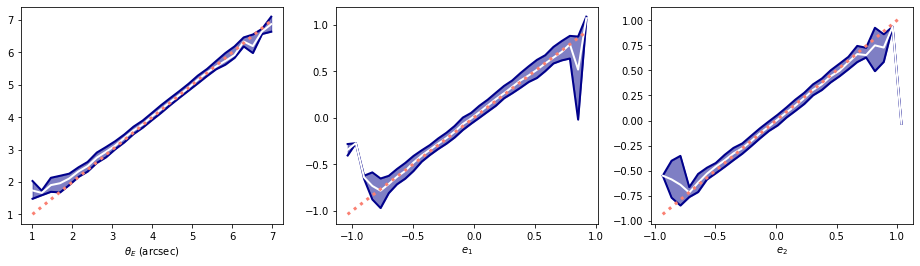

In [5]:
variables = ['thetae', 'e1', 'e2']
variables_lattex = ['$θ_E$ (arcsec)', '$e_1$', '$e_2$']

mean = []
upper_sigma = []
lower_sigma = []
X_ = []
saved_limits = []
for i in range(3):
    mean.append([])
    upper_sigma.append([])
    lower_sigma.append([])
    X_.append([])
    
for i in range(0, len(variables)):
    limits = np.histogram(dl_results[variables[i]+'_true'], bins=30)[1]
    saved_limits.append(limits)
    for j in range(0, len(limits)-1):
        if len(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])]) > 0:
            mean[i].append(np.mean(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])]))
            lower_error, upper_error = np.percentile(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])], [15.85, 84.05])
            lower_sigma[i].append(lower_error)
            upper_sigma[i].append(upper_error)
            X_[i].append(limits[j] + (limits[i+1]-limits[i])/2)
        
fig, ax = plt.subplots(1, len(variables), figsize=(16, 4))
for i in range(0, len(variables)):
    ax[i].fill_between(np.array(X_[i]), np.array(lower_sigma[i]), np.array(upper_sigma[i]), color = 'darkblue', alpha=0.5, zorder=1)
    ax[i].plot(X_[i], np.array(lower_sigma[i]), 'darkblue', lw=2, zorder=2)
    ax[i].plot(X_[i], np.array(upper_sigma[i]), 'darkblue', lw=2, zorder=2)
    ax[i].plot(X_[i], mean[i], "w", lw=2, zorder=2)
    ax[i].plot(X_[i],X_[i], 'salmon', lw=3., linestyle='dotted', zorder=3)
    ax[i].set_xlabel(variables_lattex[i])

In [6]:
bayes_sys_fit = metadata.iloc[dl_results['sys']]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'] < 6.) & (bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'] > 2.)]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'] < .6) & (bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'] > -0.6)]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'] < .6) & (bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'] > -0.6)]
bayes_sys_fit.reset_index(inplace=True)

In [7]:
bayes_sys_fit.head()

,index,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,6724,6724,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.532287,5.285532,0.532287,5.285532,0.532287,5.285532,0.532287,5.285532,0.532287,5.285532
1,6474,6474,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.371718,2.164725,0.371718,2.164725,0.371718,2.164725,0.371718,2.164725,0.371718,2.164725
2,4680,4680,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.895157,4.161542,0.895157,4.161542,0.895157,4.161542,0.895157,4.161542,0.895157,4.161542
3,863,863,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.691499,3.602060,0.691499,3.602060,0.691499,3.602060,0.691499,3.602060,0.691499,3.602060
4,7287,7287,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.479388,3.174777,0.479388,3.174777,0.479388,3.174777,0.479388,3.174777,0.479388,3.174777


In [8]:
pixel_scale = bayes_sys_fit['pixel_scale-g'][0]
exposure_time = bayes_sys_fit['exposure_time-g'][0]
N_sys = 10

cutouts = []
psf = []
noise_map = []
for i in range(N_sys):
    cutouts.append ([])
    psf.append([])
    noise_map.append([])

for i in range(N_sys):
    for j in range(0, len(bands_simulated)):
        cutouts[i].append(fits.open(image_pre_path+bands_simulated[j]+'/'+str(bayes_sys_fit['OBJID-g'][i])+'.fits')[0].data)
        kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': bayes_sys_fit['seeing-'+bands_simulated[j]][i], 'pixel_size': bayes_sys_fit['pixel_scale-g'][0], 'truncation': 4/bayes_sys_fit['seeing-'+bands_simulated[j]][i]}
        psf_class = PSF(**kwargs_psf)
        psf[i].append(psf_class.kernel_point_source/np.max(psf_class.kernel_point_source))
        noise_map[i].append(np.sqrt((cutouts[i][j]*exposure_time+float(bayes_sys_fit['sky_brightness-'+str(bands_simulated[j])][i]**2)))/exposure_time)

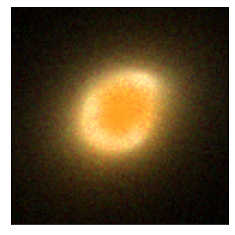

In [9]:
view_image_rgb(cutouts[0])

## building inner and outter lens light 

* lens light mask

In [10]:
image_model_optionlist = np.linspace(0, len(cutouts), len(cutouts)+1, dtype=int)

In [11]:
def update_graph(n):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                                  al.Array2D.manual(np.array(noise_map[n][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                  al.Kernel2D.manual(np.array(psf[n][2], dtype=float), pixel_scales=float(pixel_scale))) # psf

    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=1.2)
    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)

    visuals_2d = aplt.Visuals2D()
    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)
    array_plotter.figure_2d()
    
n = widgets.Dropdown(options=image_model_optionlist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,n = n)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0),…

* lens system mask

In [12]:
def update_graph(n):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][0], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                                  al.Array2D.manual(np.array(noise_map[n][0], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                  al.Kernel2D.manual(np.array(psf[n][0], dtype=float), pixel_scales=float(pixel_scale))) # psf

    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=8.0)
    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)

    visuals_2d = aplt.Visuals2D()
    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)
    array_plotter.figure_2d()
    
n = widgets.Dropdown(options=image_model_optionlist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,n = n)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0),…

## modelization 

In [85]:
class apply_pipeline:
    def __init__(self, imaging_object, system_identifier_name, lens_redshift, source_redshift, core_usage=3):
        
        self.imaging_object = imaging_object
        self.system_identifier_name = system_identifier_name
        self.lens_redshift = lens_redshift
        self.source_redshift = source_redshift
        self.core_usage = core_usage
        
    def fit_lens_light(self, nlive, lens_light_radius=1.2):
        # applying a mask
        mask = al.Mask2D.circular(shape_native=self.imaging_object.shape_native, pixel_scales=self.imaging_object.pixel_scales, radius=lens_light_radius)
        masked_object = self.imaging_object.apply_mask(mask=mask)
        # model
        source_bulge = af.Model(al.lp.EllDevVaucouleurs)
        source_galaxy_model = af.Model(al.Galaxy,
                                         redshift=self.source_redshift,
                                         bulge_0=source_bulge)
        lens_galaxy_model = af.Model(al.Galaxy,
                                       redshift=self.lens_redshift)
        # combining our previous components
        lens_light_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
        # autolens fit full bright distribution
        search = af.DynestyStatic(path_prefix = './',
                                  unique_tag = str(self.system_identifier_name)+'_lens_light_step_0',
                                  nlive = nlive,
                                  number_of_cores = self.core_usage) # be carefull here! verify your core numbers
        analysis = al.AnalysisImaging(dataset=masked_object)
        step_0_result = search.fit(model=lens_light_model, analysis=analysis)
        return step_0_result
    
    def fit_system(self, original_image, original_noise_map, original_psf, unmasked_lens_model, nlive, pixel_scale, prior_variables=[], predictions_dataframe=[], lower_limits=[], upper_limits=[], system_radius=8.0, use_predictions=False):
        original_image = al.Array2D.manual(np.array(original_image, dtype=float), pixel_scales=float(pixel_scale))
        residual_image = original_image - unmasked_lens_model
        new_image_object = al.Imaging(residual_image, # cutout
                                      al.Array2D.manual(np.array(original_noise_map, dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                      al.Kernel2D.manual(np.array(original_psf, dtype=float), pixel_scales=float(pixel_scale))) # psf

        mask = al.Mask2D.circular(shape_native=new_image_object.shape_native, pixel_scales=new_image_object.pixel_scales, radius=system_radius)
        masked_object = new_image_object.apply_mask(mask=mask)

        # source galaxy model
        bulge = af.Model(al.lp.EllDevVaucouleurs)
        source_galaxy_model = af.Model(al.Galaxy,
                                       redshift=self.source_redshift,
                                       bulge=bulge)
        # lens galaxy model
        lens_galaxy_model = af.Model(al.Galaxy,
                                     redshift=self.lens_redshift ,
                                     mass=al.mp.EllIsothermal)    
        if use_predictions:
            priors = []
            for n in range(0, len(prior_variables)):
                lowest_index = np.where(np.abs(lower_limits[n]-predictions_dataframe[prior_variables[n]+'_pred'][0]) == np.min(np.abs(lower_limits[n]-predictions_dataframe[prior_variables[n]+'_pred'][0])))[0][0]
                highest_index = np.where(np.abs(upper_limits[n]-predictions_dataframe[prior_variables[n]+'_pred'][0]) == np.min(np.abs(upper_limits[n]-predictions_dataframe[prior_variables[n]+'_pred'][0])))[0][0]+1
                priors.append([predictions_dataframe[prior_variables[n]+'_pred'][0]-2*np.abs(predictions_dataframe[prior_variables[n]+'_pred'][0]-lower_limits[n][lowest_index]), predictions_dataframe[prior_variables[n]+'_pred'][0]+2*np.abs(predictions_dataframe[prior_variables[n]+'_pred'][0]-upper_limits[n][highest_index])]) 

            # colocar dentro do loop quando estiver tudo certo com as previsoes via DL
            lens_galaxy_model.mass.einstein_radius = af.UniformPrior(lower_limit=priors[0][0], upper_limit=priors[0][1])

        autolens_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
        
        # autolens fit full bright distribution
        search = af.DynestyStatic(path_prefix = './',
                                  unique_tag = str(self.system_identifier_name) + '_lens_light_step_1',
                                  nlive = nlive,
                                  number_of_cores = self.core_usage) # be carefull here! verify your core numbers
        analysis = al.AnalysisImaging(dataset=masked_object)
        step_1_result = search.fit(model=autolens_model, analysis=analysis) # fbd = full bright distribution
        return step_1_result

In [86]:
imaging_0 = al.Imaging(al.Array2D.manual(np.array(cutouts[0][0], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                       al.Array2D.manual(np.array(noise_map[0][0], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                       al.Kernel2D.manual(np.array(psf[0][0], dtype=float), pixel_scales=float(pixel_scale))) # psf
zl = bayes_sys_fit['PLANE_1-REDSHIFT-g'][0]
zs = bayes_sys_fit['PLANE_2-REDSHIFT-g'][0]

In [87]:
pipeline = apply_pipeline(imaging_0, 0, zl, zs)

In [88]:
result = apply_pipeline.fit_lens_light(pipeline, nlive=30, lens_light_radius=1.2)

2022-03-07 16:24:03,702 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-07 16:24:03,704 - root - INFO - Starting search
2022-03-07 16:24:03,754 - root - INFO - Already completed, skipping non-linear search.
2022-03-07 16:24:03,767 - root - INFO - Removing zip file


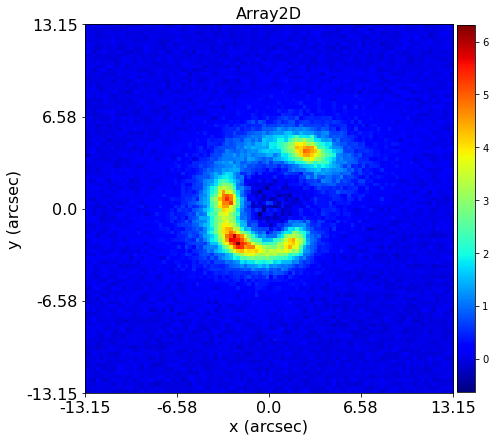

In [89]:
# cell to realize a cross-check analysis, if everything is ok them proceed
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=imaging_0.image - result.unmasked_model_image, visuals_2d=visuals_2d)
array_plotter.figure_2d()

In [90]:
len(result.unmasked_model_image)

10000

In [91]:
prior_variables=[], predictions_dataframe=[], lower_limits=[], upper_limits=[], system_radius=8.0

array([[ 0.01038896,  0.02925768,  0.0157924 , ...,  0.08872155,
         0.12810176,  0.06808287],
       [ 0.08372544,  0.02931527, -0.03761777, ...,  0.04023414,
         0.21551068,  0.11795385],
       [-0.02214889,  0.08398411,  0.02014589, ...,  0.23658961,
         0.02769664,  0.05778596],
       ...,
       [ 0.04873362, -0.03530071,  0.01045539, ..., -0.04744082,
         0.00634443,  0.03486966],
       [ 0.03083409,  0.0503257 ,  0.05063158, ...,  0.05408765,
         0.10233359,  0.08146775],
       [-0.11176296,  0.03163459, -0.0255341 , ..., -0.04507901,
        -0.01475832, -0.00551648]])

In [93]:
pipeline.fit_system(cutouts[0][0], noise_map[0][0], psf[0][0], result.unmasked_model_image, nlive=30, pixel_scale=pixel_scale, prior_variables=variables, predictions_dataframe=dl_results, lower_limits=lower_sigma, upper_limits=upper_sigma,  use_predictions=True)

[-0.02680989 -0.00872534 -0.02298962 ... -0.08396645 -0.05284213
 -0.04281167]
[[3.5655936317443837, 4.003657411575317], [0.201628571242094, 0.31987160706520085], [0.4507547781467439, 0.6559775739908218]]
2022-03-07 16:25:41,447 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-07 16:25:41,449 - root - INFO - Starting search
2022-03-07 16:25:41,454 - root - INFO - Saving path info
2022-03-07 16:25:41,508 - root - INFO - Not complete. Starting non-linear search.
2022-03-07 16:25:41,511 - root - INFO - number_of_cores == 3...
2022-03-07 16:25:41,512 - root - WARNING - ...using SneakyPool. This copies the likelihood functionto each process on instantiation to avoid copying multipletimes.
2022-03-07 16:25:41,522 - process 0 - INFO - created
2022-03-07 16:25:41,544 - process 1 - INFO - created
2022-03-07 16:25:41,564 - process 2 - INFO - created
2022-03-07 16:25:41,786 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to pri

/home/joao/.local/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
669it [00:33, 19.72it/s, +30 | bound: 148 | nc: 1 | ncall: 5032 | eff(%): 13.891 | loglstar:   -inf < 90.497 <    inf | logz: 64.434 +/-  7.599 | dlogz:  1.099 >  0.039]    


2022-03-07 16:26:16,505 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).


1381it [00:34, 39.84it/s, +30 | bound: 333 | nc: 1 | ncall: 10033 | eff(%): 14.064 | loglstar:   -inf < 319.073 <    inf | logz: 274.063 +/-  7.629 | dlogz:  0.024 >  0.039]


2022-03-07 16:27:05,664 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).


1472it [00:05, 269.32it/s, +30 | bound: 357 | nc: 1 | ncall: 10704 | eff(%): 14.032 | loglstar:   -inf < 319.073 <    inf | logz: 274.066 +/-  7.624 | dlogz:  0.001 >  0.039]


2022-03-07 16:27:25,656 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


1472it [00:00, 610442.50it/s, +30 | bound: 357 | nc: 1 | ncall: 10704 | eff(%): 14.032 | loglstar:   -inf < 319.073 <    inf | logz: 274.066 +/-  7.624 | dlogz:  0.001 >  0.039]


2022-03-07 16:27:39,968 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-07 16:27:53,926 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-03-07 16:28:26,787 - root - INFO - Removing zip file
